# EDA
So first I began with the EDA of the dataset we have. 
I first imported the required libraries for the EDA on the audio dataset. 

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import zscore
import warnings

# Ignoring these warnings for better output display
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#### Below is the duration of the audio files and their counts displayed using a histogram

100%|██████████| 409/409 [00:41<00:00,  9.78it/s]


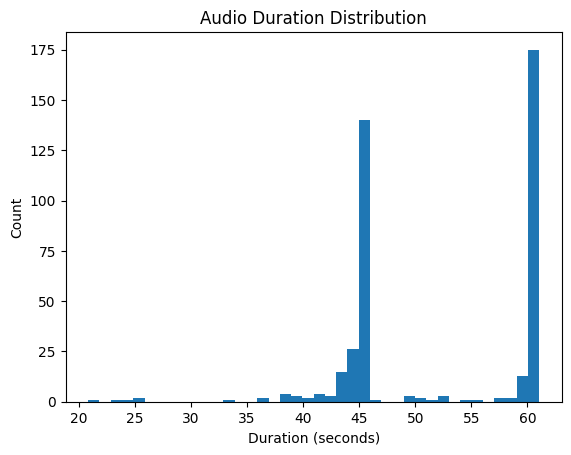

In [4]:
def get_audio_duration(path):
    y, sr = librosa.load(path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

audio_dir = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train"
durations = []

for f in tqdm(os.listdir(audio_dir)):
    if f.endswith(".wav"):
        durations.append(get_audio_duration(os.path.join(audio_dir, f)))

durations = np.array(durations)
plt.hist(durations, bins=40)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Audio Duration Distribution")
plt.show()

#### The dataset exhibits a bimodal distribution with strong peaks around 45s and 60s, indicating fixed-duration speech prompts. This reduces variability due to utterance length but may limit generalization to spontaneous or short-duration speech

#### Silence Ratio (Fluency Proxy)
This measures the pause patterns in the audio files. 

100%|██████████| 409/409 [00:45<00:00,  9.06it/s]


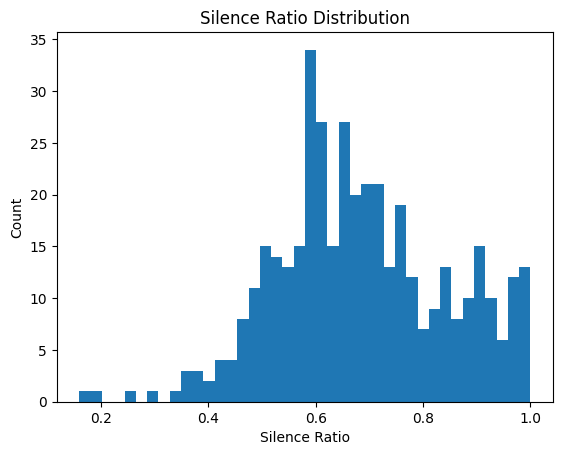

In [5]:


def silence_ratio(path, threshold=0.02):
    y, _ = librosa.load(path, sr=None)
    energy = np.abs(y)
    silence = np.sum(energy < threshold)
    return silence / len(y)

silence_ratios = []

for f in tqdm(os.listdir(audio_dir)):
    if f.endswith(".wav"):
        silence_ratios.append(silence_ratio(os.path.join(audio_dir, f)))

silence_ratios = np.array(silence_ratios)

plt.hist(silence_ratios, bins=40)
plt.xlabel("Silence Ratio")
plt.ylabel("Count")
plt.title("Silence Ratio Distribution")
plt.show()


#### This suggests that:-
#### 1.   The silence ratio distribution shows that most audio samples contain a high proportion of silence, with the majority of values concentrated between 0.5 and 0.8. This indicates that 50–80% of the audio duration consists of pauses or non-speech segments.
#### 2.   The high silence ratios suggest that speakers pause frequently, which is typical of: Spontaneous speech, Cognitive load during grammatical formulation, Non-native or low-fluency speakers. This aligns well with a spoken grammar assessment setting, where hesitation, self-correction, and planning pauses are expected.

### Pitch Stability (Grammar Delivery Quality)

100%|██████████| 409/409 [02:57<00:00,  2.31it/s]


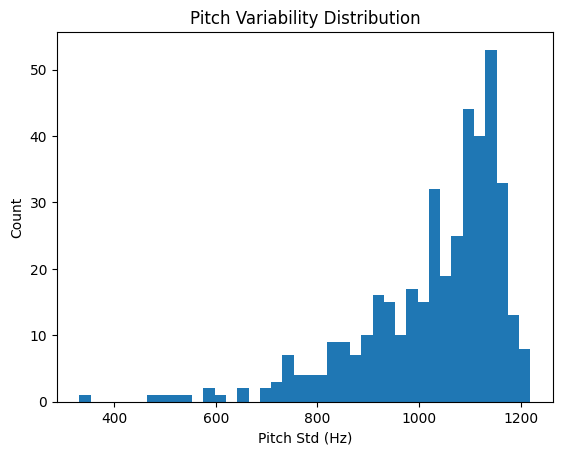

In [6]:
def pitch_stats(path):
    y, sr = librosa.load(path, sr=None)
    pitches, mags = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[mags > np.median(mags)]
    if len(pitches) == 0:
        return 0, 0
    return np.mean(pitches), np.std(pitches)

pitch_mean, pitch_std = [], []

for f in tqdm(os.listdir(audio_dir)):
    if f.endswith(".wav"):
        m, s = pitch_stats(os.path.join(audio_dir, f))
        pitch_mean.append(m)
        pitch_std.append(s)

pitch_std = np.array(pitch_std)
plt.hist(pitch_std, bins=40)
plt.xlabel("Pitch Std (Hz)")
plt.ylabel("Count")
plt.title("Pitch Variability Distribution")
plt.show()


#### Most recordings exhibit moderate to high pitch variability, indicating expressive speech patterns, while a small subset shows monotonic delivery that may reflect lower fluency rather than grammatical competence.

### MFCC Variability (Speech Consistency)

100%|██████████| 409/409 [01:44<00:00,  3.90it/s]


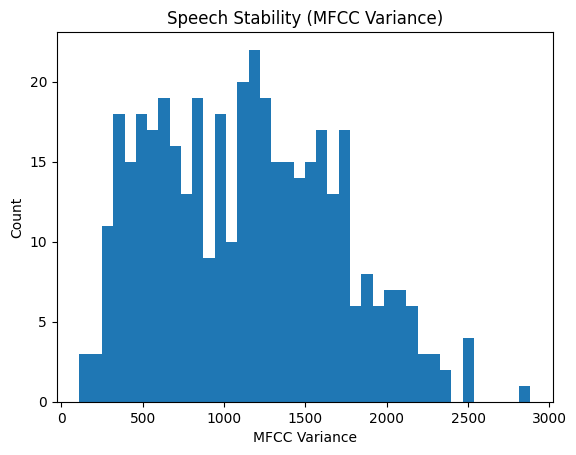

In [7]:
def mfcc_var(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(np.var(mfcc, axis=1))

mfcc_vars = []

for f in tqdm(os.listdir(audio_dir)):
    if f.endswith(".wav"):
        mfcc_vars.append(mfcc_var(os.path.join(audio_dir, f)))

mfcc_vars = np.array(mfcc_vars)
plt.hist(mfcc_vars, bins=40)
plt.xlabel("MFCC Variance")
plt.ylabel("Count")
plt.title("Speech Stability (MFCC Variance)")
plt.show()


#### The MFCC variance distribution shows a broad spread, with most samples lying between approximately 500 and 1800, and a noticeable tail extending beyond 2000. This indicates substantial variability in spectral characteristics across recordings, reflecting differences in speech stability, articulation consistency, and acoustic conditions.

### After performing EDA for Audio Data. I proceeded to transcribe the audio to get a better understanding of the actual spoken language. 

First I started with installing the openai-whisper, which will be used to transcribe the audio files. 

In [1]:
!pip install -U openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 13.5 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB

In [3]:
import whisper
import os
import pandas as pd
from tqdm import tqdm

AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train"
OUTPUT_CSV = "/kaggle/working/audio_train_transcripts.csv"

WHISPER_MODEL_SIZE = "base"   
LANGUAGE = "en"

print("Loading Whisper model...")
model = whisper.load_model(WHISPER_MODEL_SIZE)
print("Whisper model loaded")


rows = []

audio_files = sorted([
    f for f in os.listdir(AUDIO_DIR)
    if f.lower().endswith(".wav")
])

print(f"Found {len(audio_files)} audio files")

for fname in tqdm(audio_files):
    audio_path = os.path.join(AUDIO_DIR, fname)

    try:
        result = model.transcribe(
            audio_path,
            language=LANGUAGE,
            fp16=False  
        )

        transcript = result["text"].strip()

    except Exception as e:
        print(f"Error processing {fname}: {e}")
        transcript = ""

    rows.append({
        "filename": fname.replace(".wav", ""),  
        "transcript": transcript
    })


# save the results in a csv 
df = pd.DataFrame(rows)
df.to_csv(OUTPUT_CSV, index=False)

print("\nSaved transcripts to:", OUTPUT_CSV)
df.head()

Loading Whisper model...
Whisper model loaded
Found 409 audio files


100%|██████████| 409/409 [07:44<00:00,  1.14s/it]


Saved transcripts to: /kaggle/working/audio_train_transcripts.csv


,filename,transcript
0,audio_1,People in the market are selling fish in the m...
1,audio_10,"My favorite holiday destination is Bali, Indon..."
2,audio_100,"Last time I was in Baru, I remember I went to ..."
3,audio_101,"Yes, the best of my life was it that I learned..."
4,audio_102,My favorite place to visit is Puerto Rico. Thi...


## EDA For Text
Then I performed EDA over the textual transcipts. 
Then I installed the required libs and imported them as well. 

In [9]:
!pip install textstat wordcloud

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import textstat
from collections import Counter


#### Transcript Length & Sentence Structure

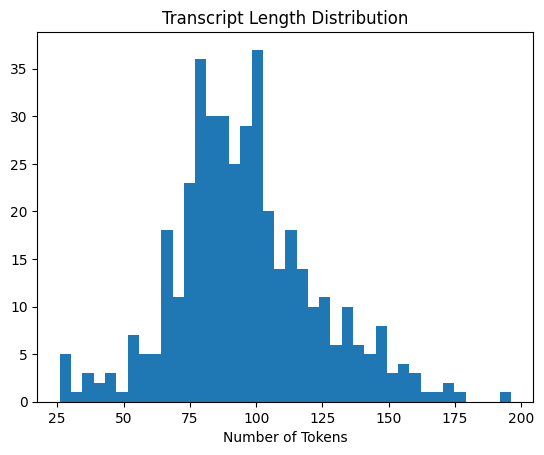

In [7]:
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("/kaggle/working/audio_train_transcripts.csv")


def length_stats(text):
    doc = nlp(text)
    tokens = [t for t in doc if not t.is_punct]
    return pd.Series({
        "num_tokens": len(tokens),
        "num_sentences": len(list(doc.sents)),
        "avg_tokens_per_sentence": len(tokens) / max(1, len(list(doc.sents)))
    })

df[["num_tokens","num_sentences","avg_tokens_per_sentence"]] = \
    df["transcript"].apply(length_stats)
plt.hist(df["num_tokens"], bins=40)
plt.xlabel("Number of Tokens")
plt.title("Transcript Length Distribution")
plt.show()


#### The histogram shows that most transcripts fall in the range of ~70 to 120 tokens, with a clear peak around 90–100 tokens. This indicates that the majority of speakers are providing responses of moderate and fairly consistent length, which is desirable for a grammar-scoring task.

#### POS Balance (Grammar Construction Signal)

In [13]:
def pos_ratios(text):
    doc = nlp(text)
    counts = Counter(t.pos_ for t in doc if t.is_alpha)
    total = sum(counts.values()) + 1
    return pd.Series({
        "verb_ratio": counts["VERB"] / total,
        "noun_ratio": counts["NOUN"] / total,
        "adj_ratio": counts["ADJ"] / total,
        "adv_ratio": counts["ADV"] / total,
        "pron_ratio": counts["PRON"] / total
    })

df[["verb_ratio","noun_ratio","adj_ratio","adv_ratio","pron_ratio"]] = \
    df["transcript"].apply(pos_ratios)


In [14]:
pos_cols = ["verb_ratio","noun_ratio","adj_ratio","adv_ratio","pron_ratio"]

df[pos_cols].describe()


,verb_ratio,noun_ratio,adj_ratio,adv_ratio,pron_ratio
count,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.129696,0.201900,0.069407,0.061064,0.144353
std,0.038198,0.055550,0.031056,0.034405,0.054141
min,0.025641,0.057143,0.000000,0.000000,0.000000
25%,0.106061,0.166667,0.047619,0.037736,0.107383
50%,0.126437,0.193548,0.068627,0.056818,0.144000
75%,0.156250,0.234234,0.089552,0.081301,0.180451
max,0.225806,0.422222,0.187500,0.201835,0.300971


#### Syntactic Complexity 
#### Measures grammar richness without error detection.

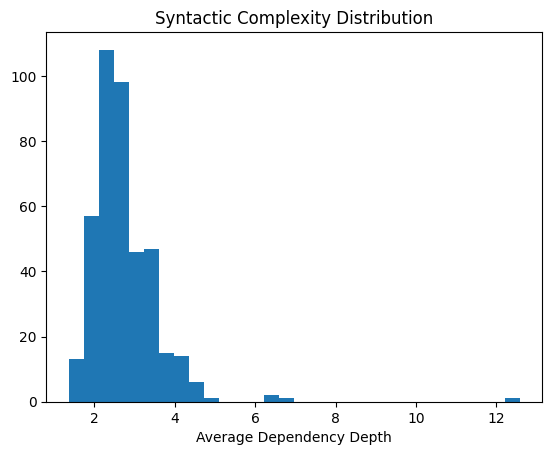

In [8]:
def syntax_complexity(text):
    doc = nlp(text)
    depths = [len(list(t.ancestors)) for t in doc if t.is_alpha]
    return np.mean(depths) if depths else 0

df["syntax_depth"] = df["transcript"].apply(syntax_complexity)
plt.hist(df["syntax_depth"], bins=30)
plt.xlabel("Average Dependency Depth")
plt.title("Syntactic Complexity Distribution")
plt.show()


#### WordCloud

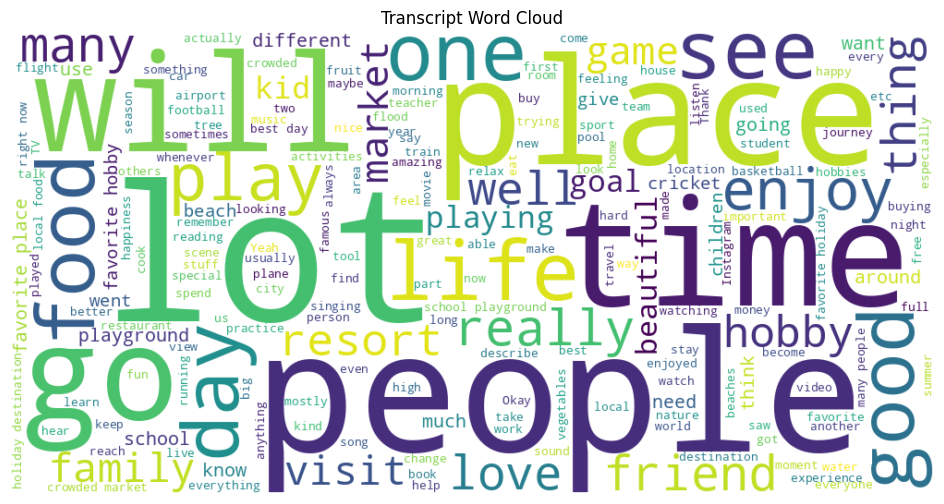

In [11]:
from wordcloud import WordCloud
all_text = " ".join(df["transcript"].dropna().astype(str))
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    max_words=200
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Transcript Word Cloud")
plt.show()


# Embedding Extraction Using PreTrained Models

After analysing the EDA results, I moved to extract the embeddings for audio & text using PreTrained Models, specifically: Whisper-base for Audio & Doberta for textual data. 
After analyzing the EDA results, embedding extraction was performed to obtain high-level, robust representations of both audio and text for the grammar scoring task. Since spoken grammar assessment depends on both speech delivery and linguistic structure, a multimodal embedding approach was necessary.

For the audio modality, Whisper-base was chosen because it is pretrained on large-scale, diverse speech data and captures important cues such as fluency, pronunciation, and temporal speech patterns, while remaining robust to noise and speaker variability. For the text modality, DeBERTa was selected due to its strong ability to model contextual and syntactic relationships, which are essential for assessing grammatical correctness and sentence structure.

Using pretrained models allows the system to leverage rich linguistic and acoustic knowledge without requiring large task-specific datasets. This approach ensures that both how the response is spoken and what is spoken are effectively represented, leading to a more reliable grammar scoring framework.

#### Audio Embedding Extraction 

For this I utilized an open source github repo for faster extraction, as that had the whole code to extract embeddings very fast, without the need to search and lookup for models. 

In [15]:
!git clone https://github.com/CodeVault-girish/SFM-models.git

import sys
sys.path.append("/kaggle/working/SFM-models")  

from sfm_extractor.extractor import model_list, extract_from
model_list()


Cloning into 'SFM-models'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 216 (delta 122), reused 158 (delta 67), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 46.71 KiB | 3.34 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Available models:
1. Trillsson
2. YAMNet
3. Facebook MMS-1B
4. SpeechBrain x-vector
5. Facebook HuBERT-base-ls960
6. Microsoft WavLM-base
7. Facebook Wav2Vec2-XLS-R-1B
8. Facebook Wav2Vec2-base
9. OpenAI Whisper-base
10. Microsoft UniSpeech-SAT-base-100h-Libri-ft
11. speechbrain/spkrec-ecapa-voxceleb


In [16]:
!touch audio_whisper_train_embeddings.csv
!touch audio_whisper_test_embeddings.csv


In [17]:
extract_from("9", "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train", output_file="/kaggle/working/audio_whisper_train_embeddings.csv", device="cuda")

2025-12-16 15:41:37.145137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765899697.300234      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765899697.349694      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Processing audio files: 100%|██████████| 409/409 [00:32<00:00, 12.60it/s]


Saved all features to /kaggle/working/audio_whisper_train_embeddings.csv


In [18]:
extract_from("9", "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test", output_file="/kaggle/working/audio_whisper_test_embeddings.csv", device="cuda")

cuda


Processing audio files: 100%|██████████| 197/197 [00:15<00:00, 12.65it/s]


Saved all features to /kaggle/working/audio_whisper_test_embeddings.csv


After this, I proceeded to extract the text embeddings from doberta model. 

In [20]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

INPUT_CSV = "/kaggle/working/audio_train_transcripts.csv"
OUTPUT_CSV = "/kaggle/working/deberta_large_embeddings_train.csv"

MODEL_NAME = "microsoft/deberta-v3-large"
MAX_LEN = 256         
BATCH_SIZE = 16

device = "cuda" if torch.cuda.is_available() else "cpu"


df = pd.read_csv(INPUT_CSV)
df["transcript"] = df["transcript"].fillna("").astype(str)

print("Total transcripts:", len(df))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()


def mean_pooling(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

def get_deberta_embeddings(texts):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device)
        )

    embeddings = mean_pooling(
        outputs.last_hidden_state,
        inputs["attention_mask"].to(device)
    )

    return embeddings.cpu().numpy()


all_embeddings = []

for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_texts = df["transcript"].iloc[i:i + BATCH_SIZE].tolist()
    emb = get_deberta_embeddings(batch_texts)
    all_embeddings.append(emb)

X = np.vstack(all_embeddings)

print("Embedding shape:", X.shape)  # (N, 768)

embedding_df = pd.DataFrame(
    X,
    columns=[f"e{i}" for i in range(X.shape[1])]
)

final_df = pd.concat(
    [df[["filename"]].reset_index(drop=True), embedding_df],
    axis=1
)

final_df.to_csv(OUTPUT_CSV, index=False)

print("Saved DeBERTa embeddings to:", OUTPUT_CSV)
final_df.head()


Total transcripts: 409


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  2.91it/s]


Embedding shape: (409, 1024)
Saved DeBERTa embeddings to: /kaggle/working/deberta_large_embeddings_train.csv


,filename,e0,e1,e2,e3,e4,e5,e6,e7,e8,...,e1014,e1015,e1016,e1017,e1018,e1019,e1020,e1021,e1022,e1023
0,audio_1,0.160433,-0.298876,0.293349,-0.343533,0.176740,0.121569,-0.326213,-0.072954,-0.034239,...,0.073268,-0.401734,0.092706,0.293174,-0.104413,-0.070079,0.209594,0.020261,-0.410799,-0.151969
1,audio_10,0.026579,-0.337997,0.241839,-0.154682,-0.141200,0.236295,0.041226,-0.075000,-0.090275,...,-0.254281,-0.287681,0.003169,0.302178,-0.379389,0.043539,-0.062799,-0.026179,-0.286123,-0.122825
2,audio_100,0.174530,-0.757789,0.427977,-0.372549,-0.032689,-0.166094,0.055326,-0.115486,-0.039065,...,-0.218566,-0.095866,0.106841,0.267897,-0.601169,-0.371354,-0.056318,0.257608,-0.943960,-0.236104
3,audio_101,0.349470,-0.453420,-0.329611,0.082522,-0.152510,0.490528,0.032058,-0.304525,0.325985,...,0.168425,-0.299094,0.062151,0.102387,-0.578286,-0.455398,-0.265878,0.274222,-1.165909,-0.196601
4,audio_102,0.226427,-0.493240,0.245226,-0.159155,0.322301,-0.103388,0.148931,-0.109624,0.057996,...,-0.091998,-0.157785,0.240422,0.238783,-0.487196,-0.268750,-0.019929,0.139042,-0.668730,-0.204408


#### After getting all the embeddings, I then trained a custom neural network over those, with separate branches for audio & text, and utilized CNN & FCN for these. 

## Complete Pipeline for Training the Model

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# 1. DATA LOADING & ALIGNMENT

def load_and_align_data(whisper_path, mpnet_path, label_path):
    whisper_df = pd.read_csv(whisper_path)
    mpnet_df   = pd.read_csv(mpnet_path)
    label_df   = pd.read_csv(label_path)

    whisper_df.rename(columns={whisper_df.columns[0]: "filename"}, inplace=True)
    mpnet_df.rename(columns={mpnet_df.columns[0]: "filename"}, inplace=True)
    label_df.rename(columns={label_df.columns[0]: "filename"}, inplace=True)

    whisper_df["filename"] = whisper_df["filename"].str.replace(
        ".wav", "", regex=False
    )

    df = (
        whisper_df
        .merge(mpnet_df, on="filename", how="inner")
        .merge(label_df, on="filename", how="inner")
    )

    return df


# 2. MODEL BRANCHES

def build_whisper_branch_no_cnn(input_dim):
    inp = tf.keras.layers.Input(shape=(input_dim,), name="whisper_input")
    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    return inp, x


def build_mpnet_branch_no_cnn(input_dim):
    inp = tf.keras.layers.Input(shape=(input_dim,), name="mpnet_input")
    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    return inp, x

def build_whisper_branch_cnn(input_dim):
    inp = tf.keras.layers.Input(shape=(input_dim,), name="whisper_input")
    x = tf.keras.layers.Reshape((input_dim, 1))(inp)

    # Conv Block 1
    x = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    return inp, x


def build_mpnet_branch_cnn(input_dim):
    inp = tf.keras.layers.Input(shape=(input_dim,), name="mpnet_input")

    x = tf.keras.layers.Reshape((input_dim, 1))(inp)

    # Conv Block 1
    x = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)

    # Dense projection
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)

    return inp, x


def build_fusion_model(whisper_dim, mpnet_dim):
    w_inp, w_feat = build_whisper_branch_cnn(whisper_dim)
    m_inp, m_feat = build_mpnet_branch_cnn(mpnet_dim)

    fused = tf.keras.layers.Concatenate()([w_feat, m_feat])
    fused = tf.keras.layers.Dense(64, activation="relu")(fused)
    fused = tf.keras.layers.Dense(8, activation="relu")(fused)

    output = tf.keras.layers.Dense(1)(fused)

    model = tf.keras.Model(
        inputs=[w_inp, m_inp],
        outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model

# 3. METRICS

def tolerance_accuracy(y_true, y_pred, tol=0.5):
    return np.mean(np.abs(y_true - y_pred) <= tol)


def evaluate_regression(model, Xw, Xm, y_true, split=""):
    y_pred = model.predict(
        {"whisper_input": Xw, "mpnet_input": Xm},
        verbose=0
    ).squeeze()

    y_pred = np.clip(y_pred, 0.0, 5.0)

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae  = np.mean(np.abs(y_true - y_pred))
    r2   = r2_score(y_true, y_pred)
    acc  = tolerance_accuracy(y_true, y_pred)

    print(f"\n=== {split} METRICS ===")
    print(f"RMSE                : {rmse:.4f}")
    print(f"MAE                 : {mae:.4f}")
    print(f"R²                  : {r2:.4f}")
    print(f"Accuracy (±0.5)     : {acc * 100:.2f}%")

    return y_pred

# 4. MAIN PIPELINE
# Paths
WHISPER_EMB = "/kaggle/working/audio_whisper_train_embeddings.csv"
MPNET_EMB   = "/kaggle/working/deberta_large_embeddings_train.csv"
LABELS      = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv"

# Load data
df = load_and_align_data(WHISPER_EMB, MPNET_EMB, LABELS)
print("Total aligned samples:", len(df))

# Split features
X_whisper = df.iloc[:, 1:513].values.astype(np.float32)    # 512-d
X_mpnet   = df.iloc[:, 513:-1].values.astype(np.float32)  # 1024-d
y         = df.iloc[:, -1].values.astype(np.float32)

# Train / test split
Xw_tr, Xw_te, Xm_tr, Xm_te, y_tr, y_te = train_test_split(
    X_whisper,
    X_mpnet,
    y,
    test_size=0.2,
    random_state=42
)

# Build model
model = build_fusion_model(
    whisper_dim=Xw_tr.shape[1],
    mpnet_dim=Xm_tr.shape[1]
)

model.summary()

# 5. CALLBACKS

BEST_MODEL_PATH = "/kaggle/working/best_whisper_doberta_fusion_model.keras"

checkpoint_cb = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# 6. TRAIN

history = model.fit(
    {"whisper_input": Xw_tr, "mpnet_input": Xm_tr},
    y_tr,
    validation_data=(
        {"whisper_input": Xw_te, "mpnet_input": Xm_te},
        y_te
    ),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint_cb, early_stop_cb],
    verbose=1
)

# 7. LOAD BEST MODEL
best_model = tf.keras.models.load_model(BEST_MODEL_PATH)
print("\nLoaded best model from:", BEST_MODEL_PATH)

# 8. EVALUATION
_ = evaluate_regression(best_model, Xw_tr, Xm_tr, y_tr, "TRAIN")
_ = evaluate_regression(best_model, Xw_te, Xm_te, y_te, "TEST")

# 9. SAVE FINAL MODEL

FINAL_MODEL_PATH = "/kaggle/working/final_best_whisper_mpnet_fusion_model.keras"
best_model.save(FINAL_MODEL_PATH)

print("\nFinal best model saved at:", FINAL_MODEL_PATH)


Total aligned samples: 409


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mpnet_input         │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ whisper_input       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 1024, 1)   │          0 │ mpnet_input[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 512, 1)    │          0 │ whisper_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 1024, 64)  │        256 │ reshape_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 512, 64)   │        256 │ reshape_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 64)  │        256 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 256, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 32768)     │          0 │ max_pooling1d_19… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 16384)     │          0 │ max_pooling1d_18… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 64)        │  2,097,216 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 128)       │  2,097,280 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 8)         │        520 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 136)       │          0 │ dense_54[0][0],   │
│ (Concatenate)       │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │      8,768 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 8)         │        520 │ dense_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 1)         │          9 │ dense_58[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 4,205,337 (16.04 MB)

 Trainable params: 4,205,081 (16.04 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 32.1314 - mae: 2.9786
Epoch 1: val_loss improved from inf to 7.85576, saving model to /kaggle/working/best_whisper_doberta_fusion_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 30.9100 - mae: 2.8919 - val_loss: 7.8558 - val_mae: 2.7112
Epoch 2/200
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5925 - mae: 0.6295 
Epoch 2: val_loss improved from 7.85576 to 7.70945, saving model to /kaggle/working/best_whisper_doberta_fusion_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6085 - mae: 0.6332 - val_loss: 7.7094 - val_mae: 2.6841
Epoch 3/200
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5357 - mae: 0.5879 
Epoch 3: val_loss improved from 7.70945 to 6.92637, saving model to /kaggle/working/best_whisper_doberta_fusion_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5509 - mae: 0.5940 - val_loss: 6.9264 - val_mae: 2.5330
Epoch 4/200
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7415 -

## Making the Predictions over test set & creating the Submissions.csv

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


TEST_META_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv"

WHISPER_TEST_EMB = "/kaggle/working/audio_whisper_test_embeddings.csv"
DEBERTA_TEST_EMB = "/kaggle/working/deberta_large_embeddings_test.csv"

FUSION_MODEL_PATH = "/kaggle/working/final_best_whisper_mpnet_fusion_model.keras"
SUBMISSION_PATH = "/kaggle/working/submission.csv"

# 1. LOAD TEST DATA

test_meta_df = pd.read_csv(TEST_META_PATH)
whisper_df = pd.read_csv(WHISPER_TEST_EMB)
deberta_df = pd.read_csv(DEBERTA_TEST_EMB)


test_meta_df["filename"] = test_meta_df["filename"].astype(str)
whisper_df["filename"] = whisper_df["filename"].astype(str)
deberta_df["filename"] = deberta_df["filename"].astype(str)

whisper_df["filename"] = whisper_df["filename"].str.replace(
    ".wav", "", regex=False
)

# 2. ALIGN ALL THREE

test_df = (
    test_meta_df
    .merge(whisper_df, on="filename", how="inner")
    .merge(deberta_df, on="filename", how="inner")
)

print("Total aligned test samples:", len(test_df))
print(test_df.head())

# 3. PREPARE FEATURES

# Whisper embeddings 
X_whisper_test = test_df.iloc[:, 1:513].values.astype(np.float32)

# DeBERTa embeddings 
X_deberta_test = test_df.iloc[:, 513:].values.astype(np.float32)

print("Whisper test shape :", X_whisper_test.shape)
print("DeBERTa test shape :", X_deberta_test.shape)

# 4. LOAD FUSION MODEL

fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
print("Loaded fusion model from:", FUSION_MODEL_PATH)

# 5. PREDICT

y_test_pred = fusion_model.predict(
    {
        "whisper_input": X_whisper_test,
        "mpnet_input": X_deberta_test
    },
    verbose=1
).squeeze()

y_test_pred = np.clip(y_test_pred, 0.0, 5.0)
# Quantize to nearest 0.5
y_test_pred = np.round(y_test_pred * 2) / 2

# 6. CREATE SUBMISSION

submission_df = pd.DataFrame({
    "filename": test_df["filename"],
    "label": y_test_pred
})

submission_df.to_csv(SUBMISSION_PATH, index=False)

print("Submission saved at:", SUBMISSION_PATH)
submission_df.head()
